# PCA on Housing Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [4]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

## Data Exploration

In [5]:
train = pd.read_csv('../data/house_train.csv')
test = pd.read_csv('../data/house_test.csv')

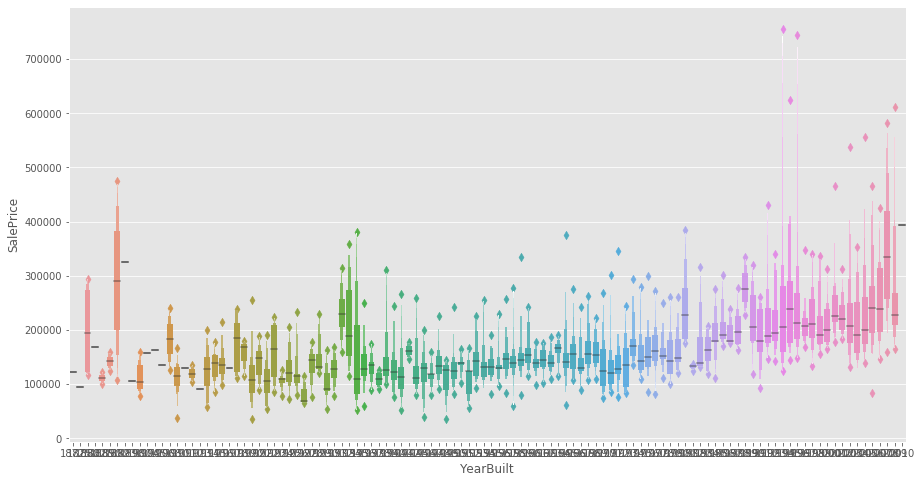

In [6]:
plt.figure(figsize=(15,8))
sns.boxenplot(train.YearBuilt, train.SalePrice)

(0, 800000)

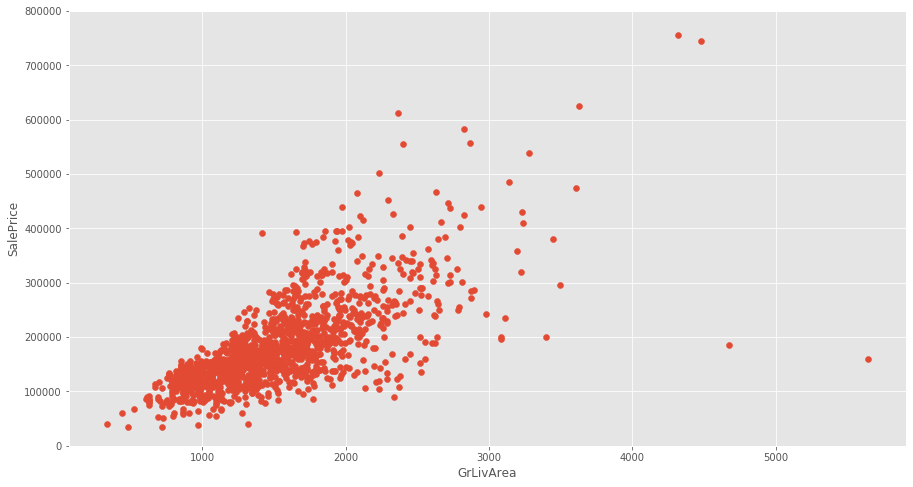

In [7]:
plt.figure(figsize=(15,8))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.ylim(0,800000)

In [8]:
train.drop(train[(train['GrLivArea']<4000) & (train['SalePrice']<300000)].index, inplace=True)

In [11]:
data = pd.concat([train, test], ignore_index=True, sort=True)

In [12]:
data.drop(['Id'], axis=1, inplace=True)

In [13]:
data.shape

(1576, 80)

## Dealing with Missing Data

In [14]:
is_null = data.isnull().sum()
is_null[is_null>0].sort_values(ascending=False)

PoolQC          1571
MiscFeature     1525
Alley           1469
SalePrice       1459
Fence           1281
FireplaceQu      734
LotFrontage      236
GarageQual        78
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        17
MasVnrArea        16
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

Let's first imput the missing values of LotFrontage based on the median of LotArea and Neighborhood. Since LotArea is a continuous feature, We use qcut to divide it into 10 parts.

In [15]:
data.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.333333   43.0     6
Blueste        28.125000   24.0     8
BrDale         21.428571   21.0    14
BrkSide        53.795455   51.0    44
ClearCr        94.750000   84.5     8
CollgCr        71.092784   70.0    97
Crawfor        69.000000   68.0    46
Edwards        69.247191   65.0    89
Gilbert        70.296875   63.0    64
IDOTRR         62.075472   60.0    53
MeadowV        23.777778   21.0    18
Mitchel        78.518519   74.0    54
NAmes          73.984211   73.5   190
NPkVill        26.071429   24.0    14
NWAmes         81.775000   80.0    40
NoRidge        94.621622   91.0    37
NridgHt        88.945736   96.0   129
OldTown        61.213115   60.0   122
SWISU          59.238095   60.0    21
Sawyer         74.660000   73.5    50
SawyerW        70.694915   70.0    59
Somerst        65.765957   73.0    94
StoneBr        65.108108   63.0    37
Timber         83.857143   85.0    35
Veenker        75.818182   80.0    11

In [16]:
data['LotAreaCut'] = pd.qcut(data.LotArea, 10)

In [17]:
data.groupby(['LotAreaCut'])[['LotArea']].agg(['mean','median','count'])

LotArea               
                             mean   median count
LotAreaCut                                      
(1469.999, 5002.5]    3177.563291   3209.0   158
(5002.5, 7040.0]      6204.563291   6230.5   158
(7040.0, 8050.0]      7573.237500   7555.0   160
(8050.0, 8803.0]      8434.548387   8410.0   155
(8803.0, 9600.0]      9253.527950   9259.0   161
(9600.0, 10389.0]     9981.019481   9971.5   154
(10389.0, 11306.5]   10811.210191  10800.0   157
(11306.5, 12585.0]   11916.746835  11850.5   158
(12585.0, 14707.5]   13527.401274  13440.0   157
(14707.5, 215245.0]  22894.810127  17492.5   158

In [18]:
data['LotFrontage'] = data.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [19]:
data['LotFrontage'] = data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [20]:
# fill-in missing values according to data description
cols = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]

for col in cols:
    data[col].fillna(0, inplace=True)

In [22]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", 
         "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2",
         "BsmtFinType1", "MasVnrType"]
for col in cols1:
    data[col].fillna("None", inplace=True)

In [23]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [24]:
data.isnull().sum()[data.isnull().sum()>0]

SalePrice    1459
dtype: int64

## Feature Engineering

Convert some numerical features into categorical features. It's better to use LabelEncoder and get_dummies for these features.

In [26]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    data[col]= data[col].astype(str)

In [28]:
data.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         341775.833333  326450.0     6
150                   NaN       NaN     0
160                   NaN       NaN     0
180                   NaN       NaN     0
190                   NaN       NaN     0
20          372292.551020  372402.0    49
30                    NaN       NaN     0
40                    NaN       NaN     0
45                    NaN       NaN     0
50          354775.000000  348800.0     4
60          378252.452830  340000.0    53
70          337050.000000  337050.0     2
75          400000.000000  400000.0     2
80          345000.000000  345000.0     1
85                    NaN       NaN     0
90                    NaN       NaN     0

In [35]:
def map_values():
    data["oMSSubClass"] = data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    data["oMSZoning"] = data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    data["oCondition1"] = data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    data["oBldgType"] = data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    data["oExterior1st"] = data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    data["oExterQual"] = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFoundation"] = data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    data["oBsmtQual"] = data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oBsmtExposure"] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    data["oHeating"] = data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    data["oHeatingQC"] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oKitchenQual"] = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFunctional"] = data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    data["oFireplaceQu"] = data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oGarageType"] = data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    data["oGarageFinish"] = data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    data["oPavedDrive"] = data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    data["oSaleType"] = data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    data["oSaleCondition"] = data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [36]:
map_values()

'Done!'

In [37]:
data.drop('LotAreaCut', axis=1, inplace=True)
data.drop(['SalePrice'], axis=1, inplace=True)

## Pipeline



    Next we can build a pipeline. It's convenient to experiment different feature combinations once you've got a pipeline.

    Label Encoding three "Year" features.



In [44]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X


In [45]:
# apply log1 to the skewed features, get_dummies
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [46]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [47]:
data2 = data.copy()

In [48]:
data_pipe = pipe.fit_transform(data2)

In [49]:
data_pipe.shape

(1576, 370)

In [50]:
data_pipe.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,7.435438,0,0.0,7.222566,0.0,5.762051,0.0,1,2,636.0,...,0,1,0,1,1,0,1,0,0,0
1,7.075809,1142,0.0,6.906755,0.0,5.181784,0.0,2,3,736.0,...,0,0,0,1,1,1,0,0,0,0
2,7.055313,1218,0.0,0.000000,0.0,7.055313,0.0,1,3,853.0,...,0,0,0,1,1,1,0,0,0,0
3,7.441320,0,0.0,7.105786,0.0,6.188264,0.0,1,2,772.0,...,0,1,0,1,1,0,0,0,0,1
4,7.032624,1320,0.0,0.000000,0.0,7.019297,0.0,1,3,691.0,...,0,1,0,1,1,1,0,0,0,0


In [51]:
scaler = RobustScaler()

n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

## PCA

In [61]:
pca = PCA(n_components=117)

In [62]:
X_scaled = pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [58]:
X_scaled.shape, test_X_scaled.shape

((117, 117), (1459, 117))

## Model Evaluation

In [63]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scorint='neg_mean_squared_error', cv=5))
    return rmse